In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys

proj_root = os.path.dirname(os.path.abspath("."))
# print(proj_root)
sys.path.append(proj_root)

import time
import datetime
import torch
import random
import numpy as np
import os
from pathlib import Path
import argparse

import torch.optim as optim
import torch.nn.functional as F

import gym 

import yaml

from minatar_dqn.replay_buffer import ReplayBuffer
from experiments.experiment_utils import seed_everything
from minatar_dqn.utils.my_logging import setup_logger
from minatar_dqn.models import Conv_QNET, Conv_QNET_one

from minatar_dqn.my_dqn import AgentDQN, build_environment
from experiments.experiment_utils import collect_training_output_files, collect_pruning_output_files

from flatten_dict import flatten
import pandas as pd
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
training_outputs_folder_path = (
    r"D:\Work\PhD\minatar_work\experiments\training\outputs"
)
training_timestamp_folder = "2023_07_13-10_44_18"

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

def get_records_from_training_experiment(experiment_files, stats_type = "validation"):
    
    checkpoint = torch.load(experiment_files["stats_path"])
    
    training_stats = checkpoint["training_stats"]
    validation_stats = checkpoint["validation_stats"]

    if stats_type == "training":
        flat_records = process_records_from_stats_and_config(training_stats, experiment_files["config_path"], stats_type)
    elif stats_type == "validation":
        flat_records = process_records_from_stats_and_config(validation_stats, experiment_files["config_path"], stats_type)
    
    return flat_records

def process_records_from_stats_and_config(stats, config_path, stats_type):

    flat_records = []
    for epoch_stats in stats:
        flat_stats = flatten(epoch_stats, reducer="underscore")  
        flat_stats["epoch_type"] = stats_type
        flat_records.append(flat_stats)

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # build experiment name cause I did not think to save some kind of 
    # exp name in config
    config_file_name = os.path.basename(config_path)

    # add info from the config file
    for record in flat_records:
        record["environment"] = config["environment"]
        record["seed"] = config["seed"]
        record["experiment_name"] = config["experiment_name"]
        
    return flat_records

def collect_training_experiment_results(experiment_paths, stats="validation", train_epoch_counter = 200_000):
    records = []
    for experiment_files in experiment_paths:
        records.extend(get_records_from_training_experiment(experiment_files, stats_type=stats))

    df = pd.DataFrame.from_records(records)
    df["epoch"] = df["frame_stamp"] // train_epoch_counter 

    return df

df = collect_training_experiment_results(experiment_paths, stats="validation")
# df = collect_training_experiment_results(experiment_paths, stats="training")

df.head()

,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,episode_frames_median,...,episode_max_qs_median,episode_max_qs_std,epoch_time,reward_contor_0,reward_contor_1,epoch_type,environment,seed,experiment_name,epoch
0,200000,0.0,22.0,2.902108,2.0,3.214387,28,839,188.509036,166.0,...,2.224319,0.570143,0 days 00:01:09.966567,123243,1927.0,validation,asterix,0,conv32_lin128,1
1,400000,0.0,78.0,35.654762,39.5,17.508497,41,1153,749.297619,839.5,...,6.387700,0.571308,0 days 00:01:23.628678,119892,5990.0,validation,asterix,0,conv32_lin128,2
2,600000,0.0,99.0,42.163399,44.0,18.774011,57,1288,822.594771,925.0,...,7.892090,0.627130,0 days 00:01:23.753022,119406,6451.0,validation,asterix,0,conv32_lin128,3
3,800000,0.0,113.0,41.592814,44.0,23.392551,39,1292,749.053892,847.0,...,7.753870,0.600959,0 days 00:01:21.647185,118146,6946.0,validation,asterix,0,conv32_lin128,4
4,1000000,0.0,106.0,44.456790,49.0,24.411619,31,1248,773.074074,926.5,...,8.133014,0.566874,0 days 00:01:25.841255,118036,7202.0,validation,asterix,0,conv32_lin128,5


In [35]:
df_pivot[(df_pivot["experiment_name"]=="conv32_lin128_pessim_1") & (df_pivot["environment"]=="space_invaders")]

,experiment_name,environment,epoch,reward_contor,counts
375,conv32_lin128_pessim_1,space_invaders,1,reward_contor_0,107912.0
376,conv32_lin128_pessim_1,space_invaders,2,reward_contor_0,103233.0
377,conv32_lin128_pessim_1,space_invaders,3,reward_contor_0,104377.0
378,conv32_lin128_pessim_1,space_invaders,4,reward_contor_0,103816.0
379,conv32_lin128_pessim_1,space_invaders,5,reward_contor_0,104286.0
...,...,...,...,...,...
1280,conv32_lin128_pessim_1,space_invaders,21,reward_contor_1,21495.0
1281,conv32_lin128_pessim_1,space_invaders,22,reward_contor_1,21759.0
1282,conv32_lin128_pessim_1,space_invaders,23,reward_contor_1,21424.0
1283,conv32_lin128_pessim_1,space_invaders,24,reward_contor_1,21476.0


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\Chainsword\anaconda3\envs\general\lib\site-p

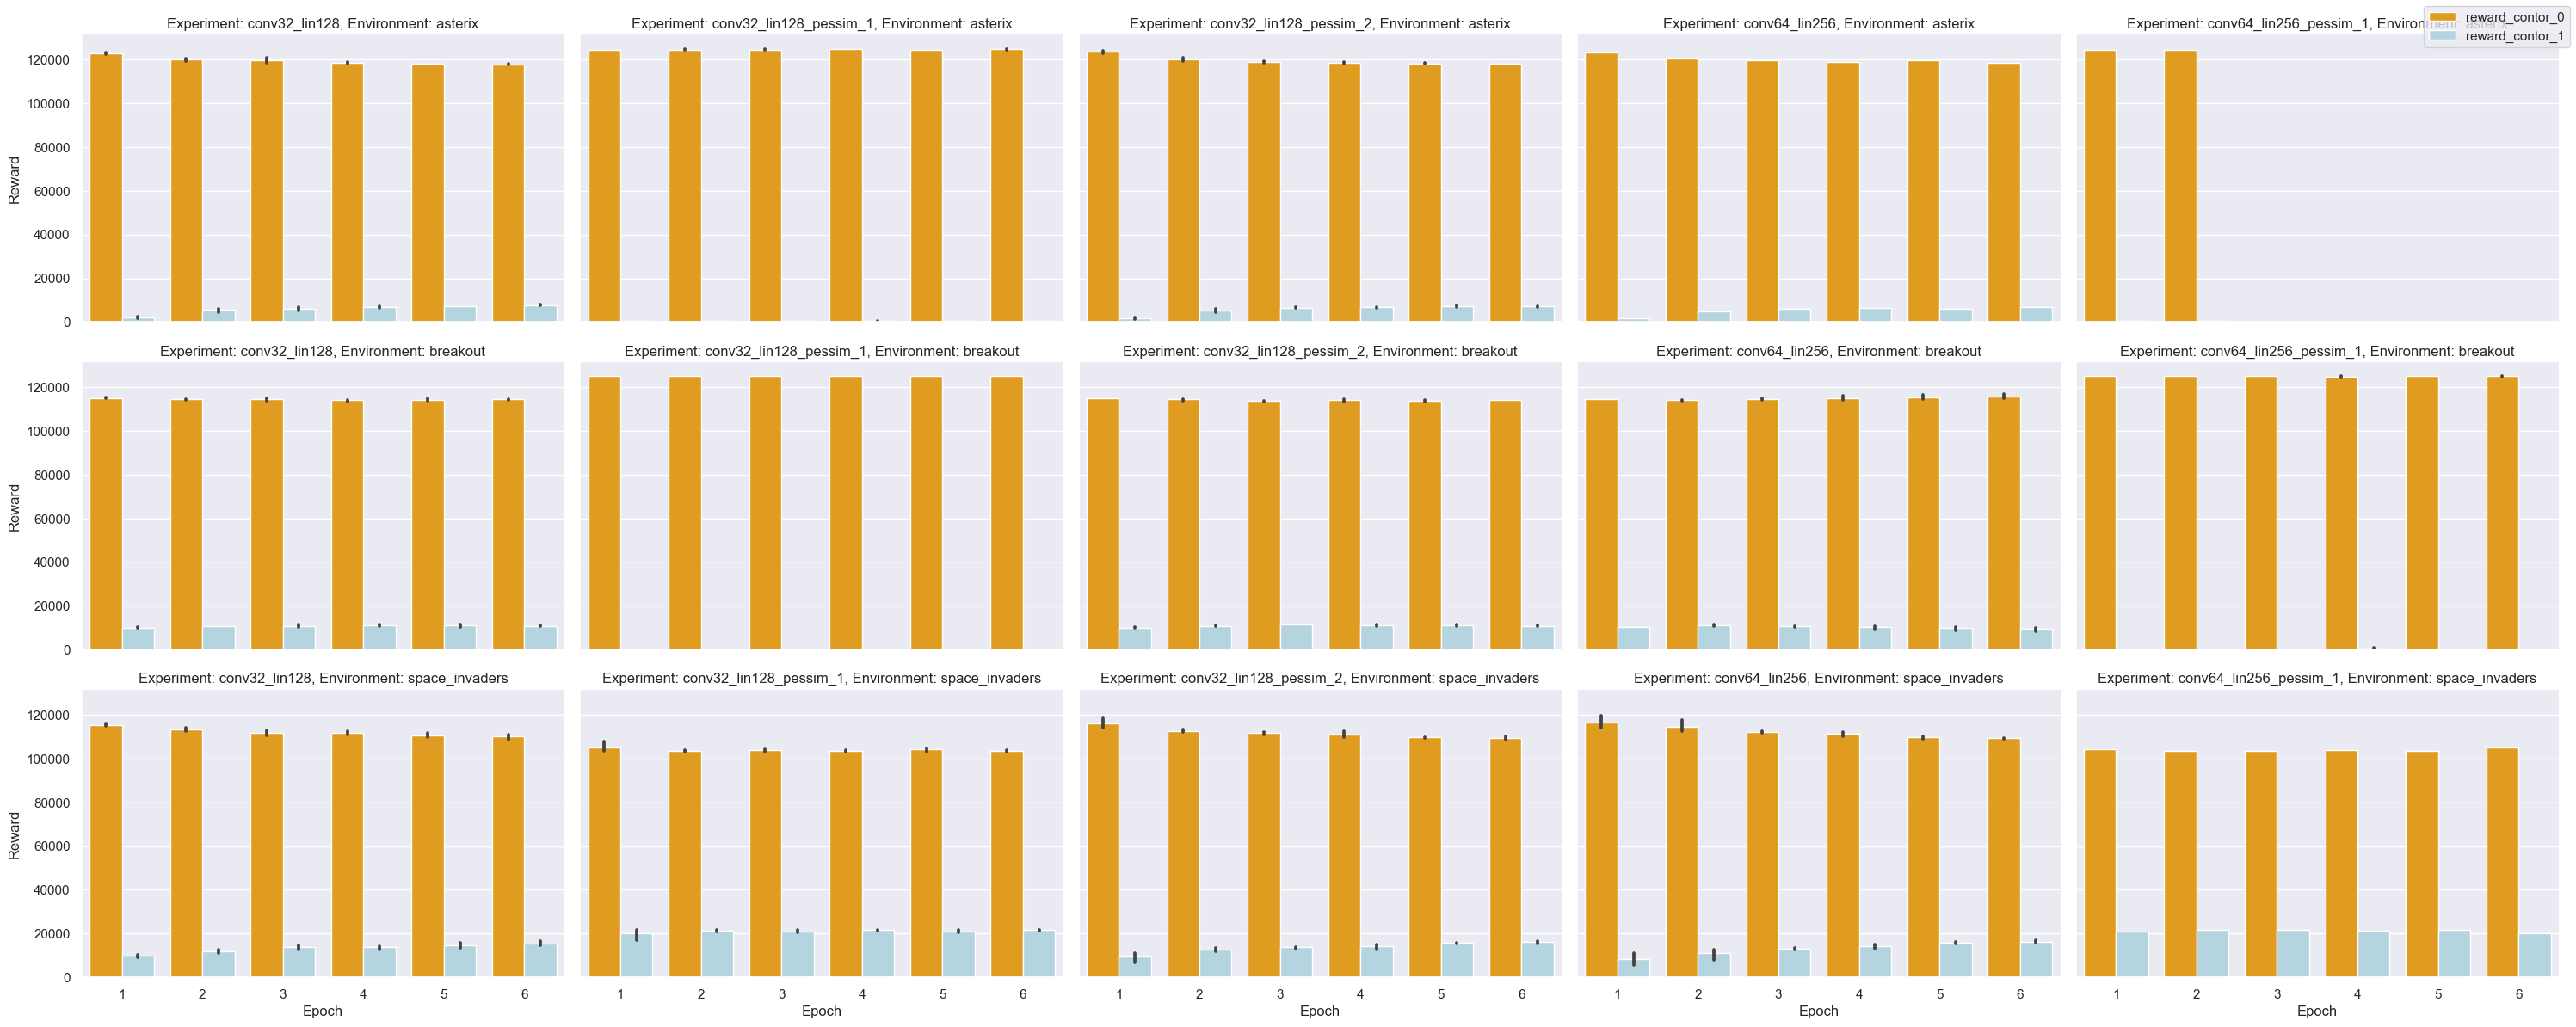

In [31]:
# Assuming your DataFrame is named `df`
df_pivot = df.melt(id_vars=['experiment_name', 'environment', 'epoch'],
                   value_vars=['reward_contor_0', 'reward_contor_1'],
                   var_name='reward_contor', value_name='counts')

g = sns.FacetGrid(df_pivot, row='environment', col='experiment_name', height=4, aspect=1.5)
order = ['reward_contor_0', 'reward_contor_1']
palette = ['orange', 'lightblue']

g.map(sns.barplot, 'epoch', 'counts', 'reward_contor', palette=palette)

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

In [18]:
df.columns

Index(['frame_stamp', 'episode_rewards_min', 'episode_rewards_max',
       'episode_rewards_mean', 'episode_rewards_median', 'episode_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_max_qs_min',
       'episode_max_qs_max', 'episode_max_qs_mean', 'episode_max_qs_median',
       'episode_max_qs_std', 'epoch_time', 'reward_contor_0',
       'reward_contor_1', 'epoch_type', 'environment', 'seed',
       'experiment_name', 'epoch'],
      dtype='object')

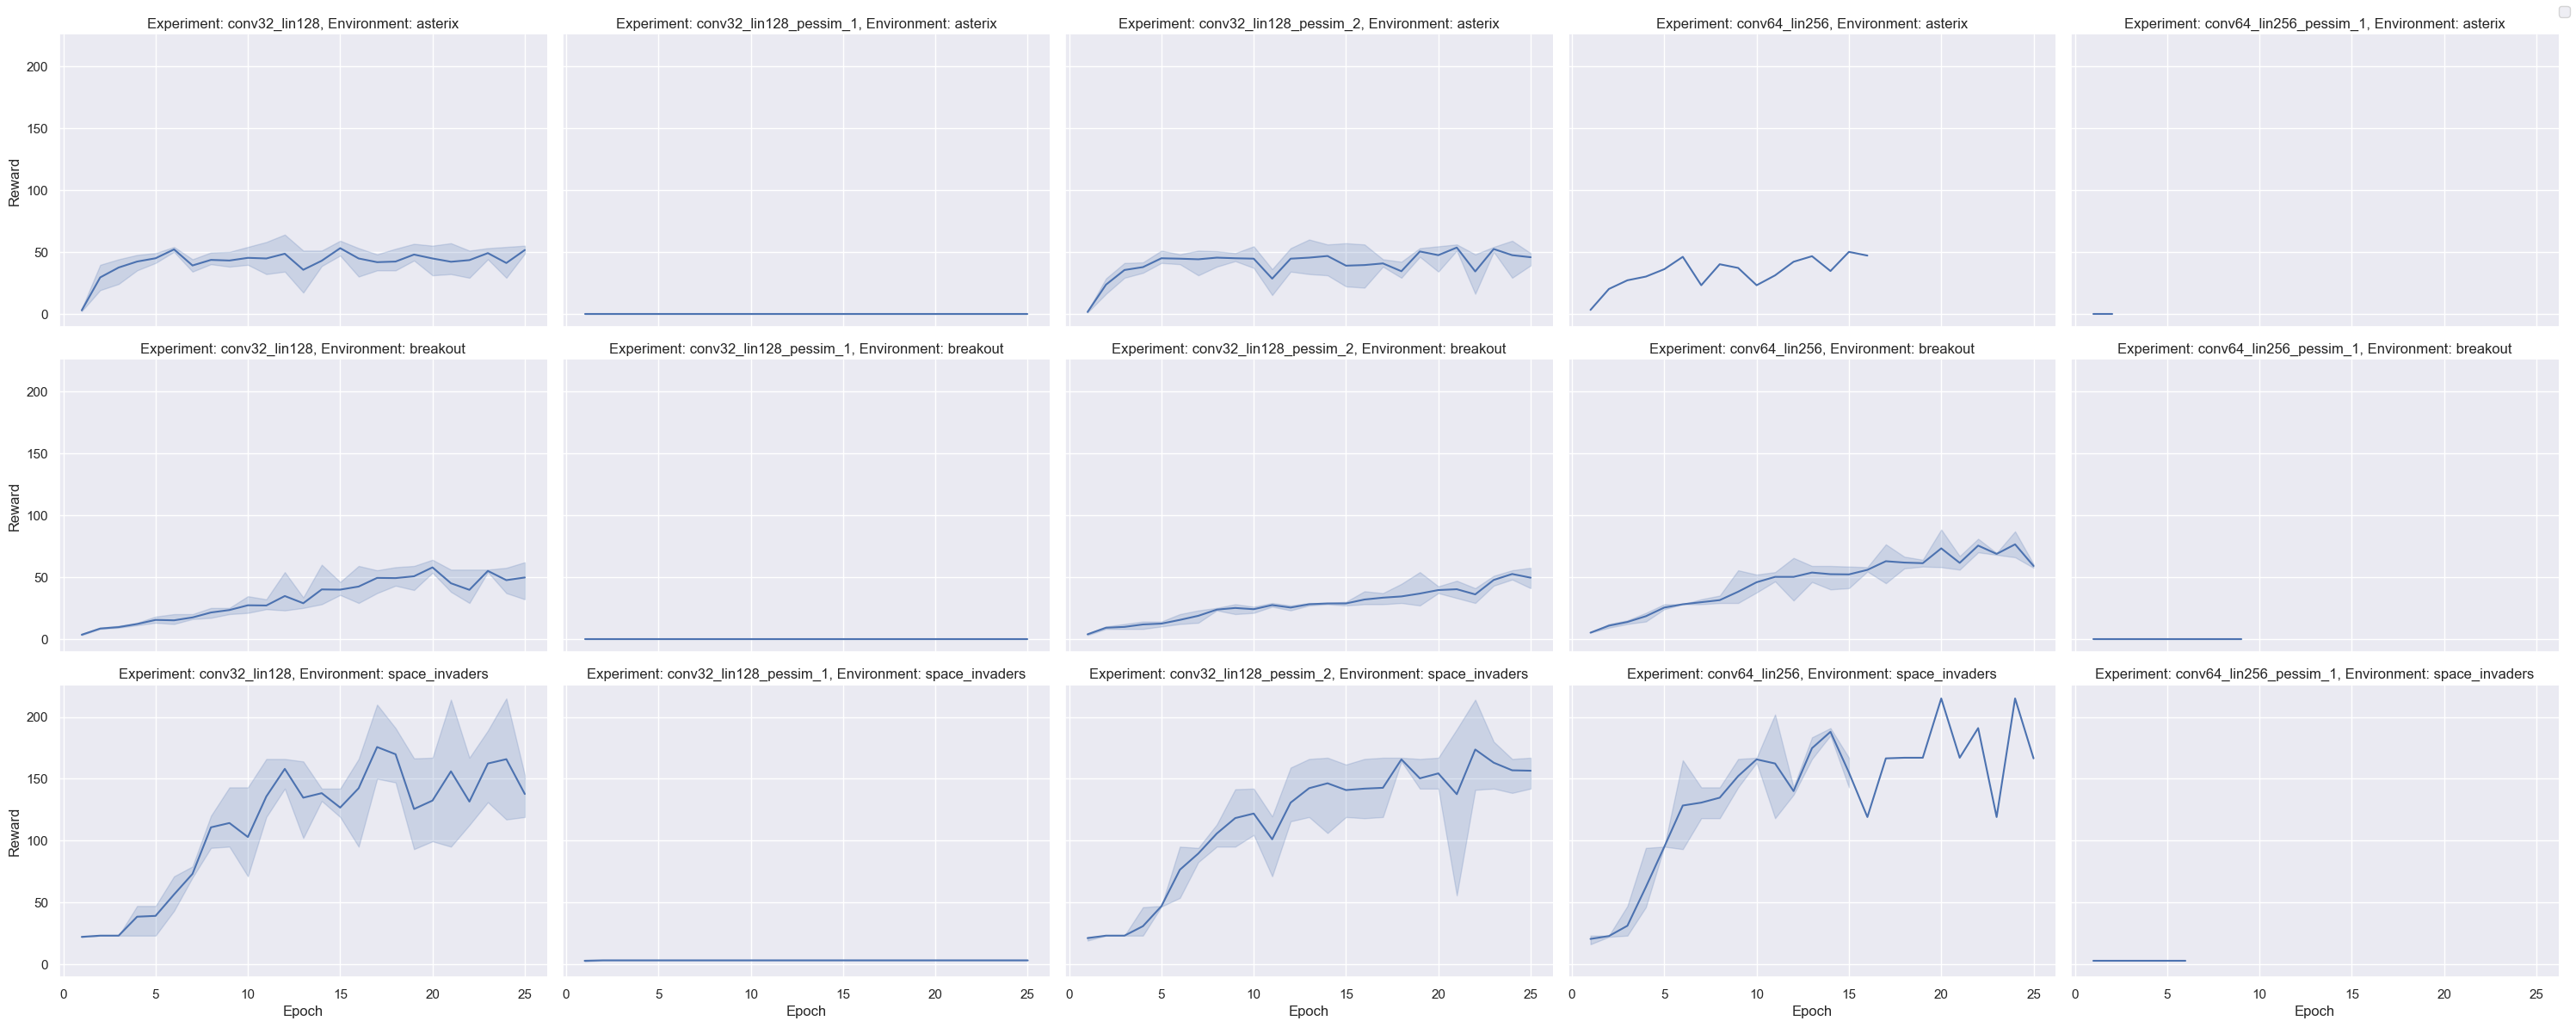

In [20]:
# Assuming your DataFrame is named `df`


g = sns.FacetGrid(df, row='environment', col='experiment_name', height=4, aspect=1.5)

g.map(sns.lineplot, 'epoch', 'episode_rewards_median')

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

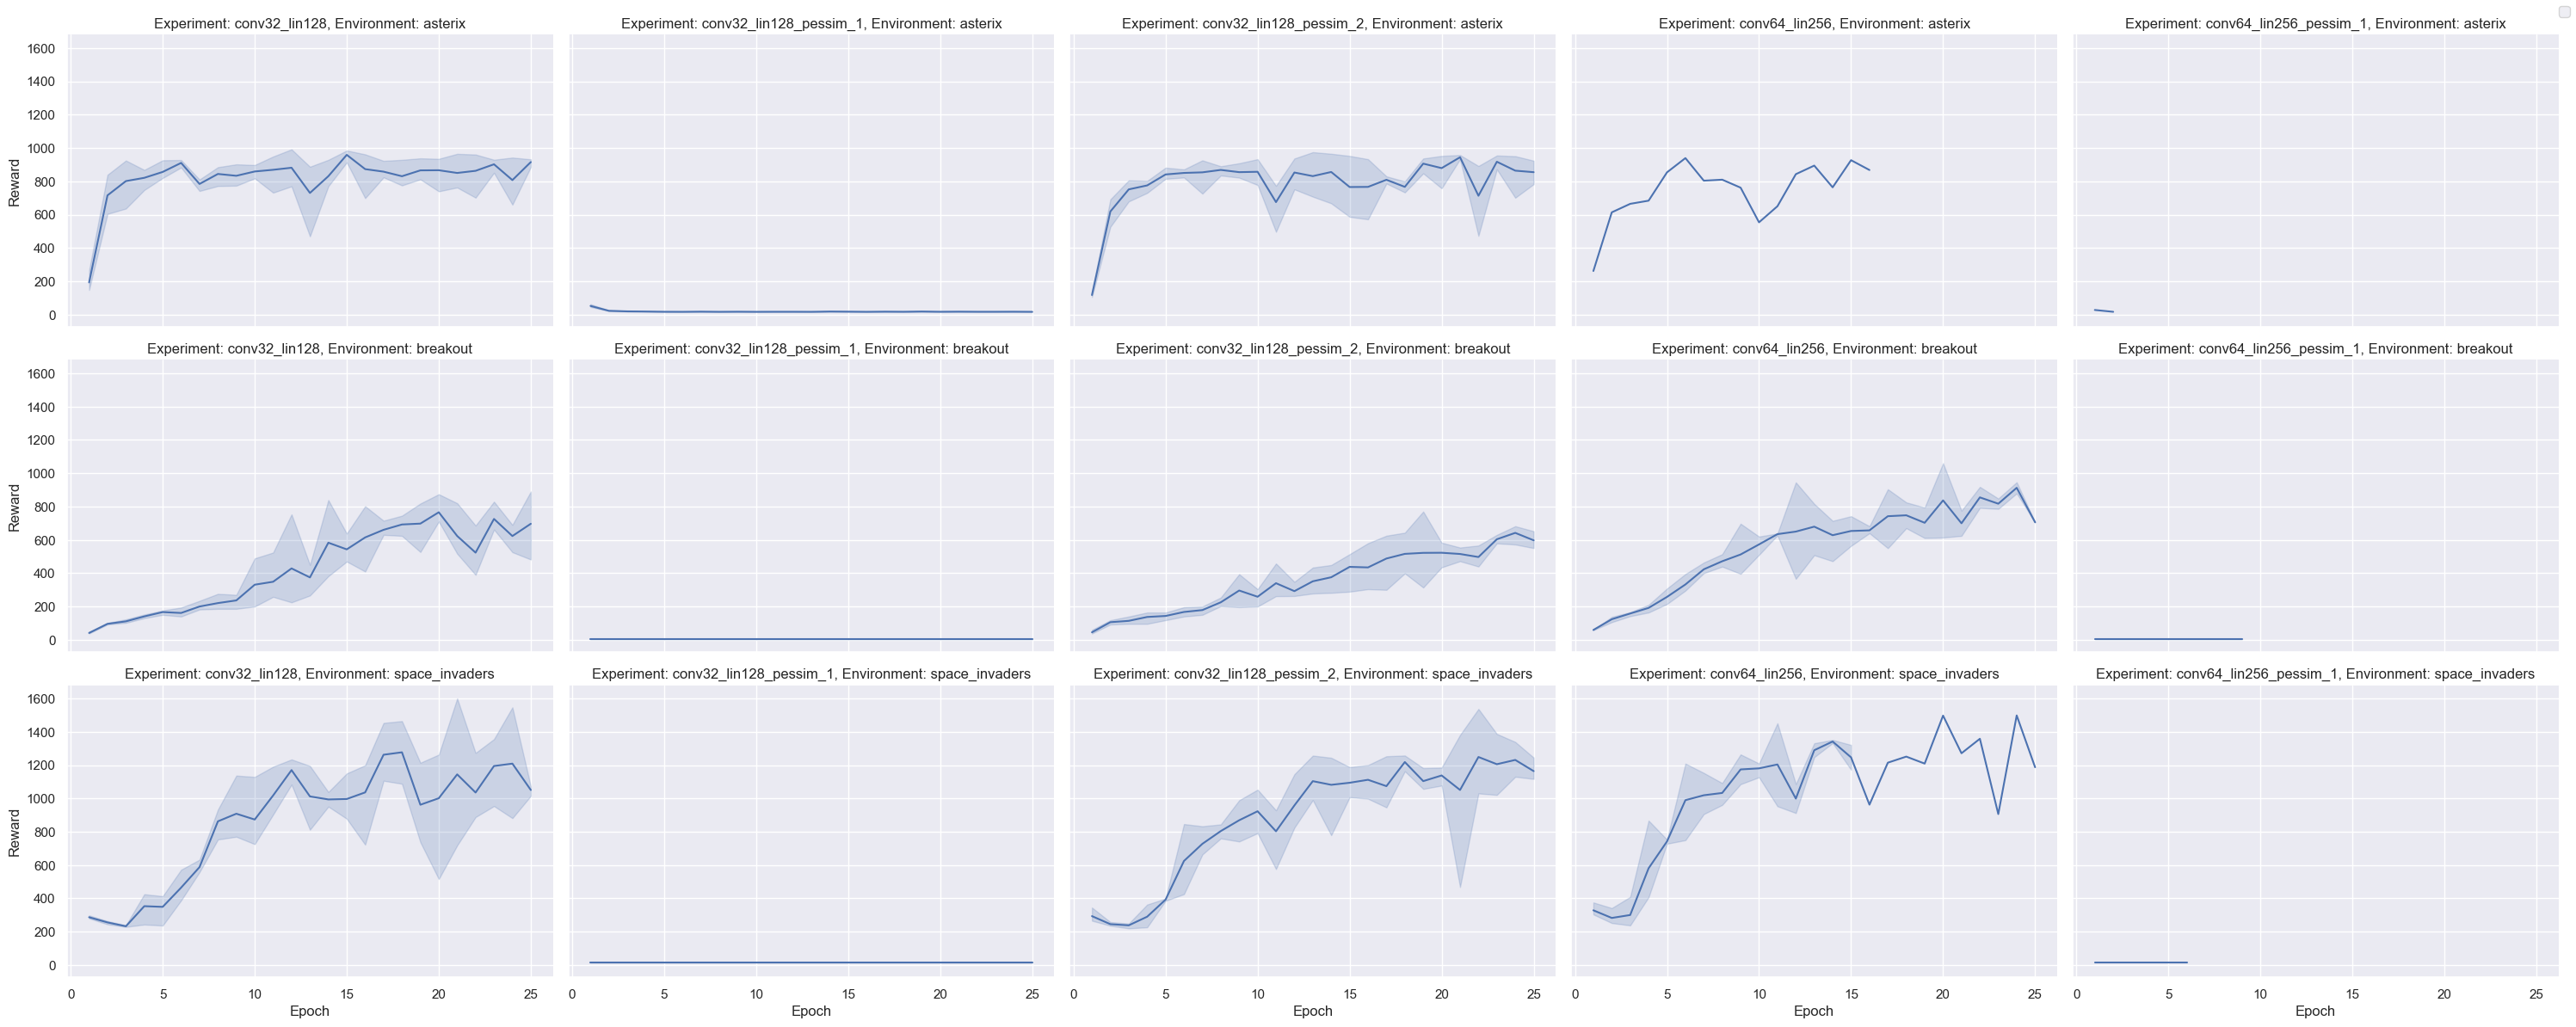

In [23]:
# Assuming your DataFrame is named `df`

g = sns.FacetGrid(df, row='environment', col='experiment_name', height=4, aspect=1.5)

g.map(sns.lineplot, 'epoch', 'episode_frames_median')

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

In [45]:
training_outputs_folder_path = (
    r"D:\Work\PhD\minatar_work\experiments\training\outputs"
)
training_timestamp_folder = "2023_07_13-03_01_30"

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

experiment_paths[0]

{'model_path': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\model_checkpoints\\mck_2',
 'training_folder_path': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0',
 'config_path': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\conv32_lin128_pessim_1_space_invaders_0_config',
 'stats_path': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\conv32_lin128_pessim_1_space_invaders_0_train_stats'}

In [46]:
sys.path.append(os.path.dirname(os.path.dirname(".")))

from minatar_dqn.my_dqn import AgentDQN, build_environment
from minatar_dqn.utils.my_logging import setup_logger


exp_files = experiment_paths[0]
with open(exp_files["config_path"], "r") as f:
    config = yaml.safe_load(f)

logger = setup_logger(
            env_name=config["environment"]
        )

### Setup environments ###
train_env = build_environment(
    game_name=config["environment"], random_seed=config["seed"]
)
validation_env = build_environment(
    game_name=config["environment"], random_seed=config["seed"]
)
    
my_agent = AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=exp_files["training_folder_path"],
    experiment_name=config["full_experiment_name"],
    resume_training_path=exp_files["training_folder_path"],
    logger=logger,
    config = config)


2023-07-13 03:11:15,814 - root - INFO - Setup reward mapping.
2023-07-13 03:11:15,815 - root - INFO - Loaded configuration settings.
2023-07-13 03:11:15,818 - root - INFO - Initialized newtworks and optimizer.
2023-07-13 03:11:15,818 - root - INFO - Applied redo parametrization to policy model.
2023-07-13 03:11:15,819 - root - INFO - Applied redo parametrization to target model.
2023-07-13 03:11:18,711 - root - INFO - Loaded previous training status from the following files: {'replay_buffer_file': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\conv32_lin128_pessim_1_space_invaders_0_replay_buffer', 'train_stats_file': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_lin128_pessim_1\\space_invaders\\0\\conv32_lin128_pessim_1_space_invaders_0_train_stats', 'checkpoint_model_file': 'D:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_13-03_01_30\\conv32_

In [50]:
res = my_agent.replay_buffer.sample(4)
res[3]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
          [0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
          [0., 1., 1., 1., 0., 1., 1., 0., 0., 0.],
          [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         

In [29]:
config

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 100,
   'train_step_cnt': 20000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 12500}},
 'environment': 'asterix',
 'epochs_to_train': 1,
 'estimator': {'args_': {'conv_hidden_out_size': 32,
   'lin_hidden_out_size': 128},
  'model': 'Conv_QNET'},
 'experiment_name': 'conv32_lin128_pessim_1',
 'experiment_output_folder': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_07_12-23_14_00\\conv32_lin128_pessim_1\\asterix\\0',
 'experiment_start_timestamp': '2023_07_12-23_14_00',
 'full_experiment_name': 'conv32_lin128_pessim_1_asterix_0',
 'optim': {'args_': {'eps': 0.00015, 'lr': 6.25e-05}, 'name': 'Adam'},
 'path_experiments_outputs': 'd:\\Work\\PhD\\minatar_work\\experiments

In [14]:
file_dir = os.path.dirname(os.path.abspath(r"D:\Work\PhD\minatar_work\experiments\training\training.py"))

sys.path.append(file_dir)

from training import get_config_paths, read_config_files, generate_run_configs

path_experiments_configs = os.path.join(file_dir, "training_configs")
path_experiments_outputs = os.path.join(file_dir, "outputs")

default_config_path, experiment_config_paths = get_config_paths(
        path_experiments_configs
    )
  
experiment_configs = read_config_files(default_config_path, experiment_config_paths)

runs_configs = generate_run_configs(experiment_configs, path_experiments_outputs)

In [37]:
from minatar_dqn.my_dqn import RewardPerception

rp = RewardPerception({0: -1, 1: 0})


In [39]:
rp.percieve_reward(0.0)

-1